In [541]:
#!pip install nltk
#!pip install gensim
#!pip install Cython

from tqdm.notebook import tqdm
import itertools
#nltk.download("reuters")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 


from string import punctuation

from nltk.corpus import reuters, stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, CategoricalNB
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from gensim.models import Word2Vec, KeyedVectors

## checking dataset

In [2]:
reuters.categories("training/9865")

['barley', 'corn', 'grain', 'wheat']

In [3]:
reuters.fileids("barley")[50]

'training/9958'

In [4]:
reuters.words("training/9865")

['FRENCH', 'FREE', 'MARKET', 'CEREAL', 'EXPORT', ...]

# 1.	Use appropriate NLTK coding to visualize the number of documents per category in the training set. Is the dataset class balanced? Motivate your answer.

## Create and visualize number of documents per category

In [5]:
frame = {"category":[], "Num_docs":[]}          # initialize frame with empty lists
for i in reuters.categories():                  # iterate through categories
    documents_num = len(reuters.fileids(i))         # get number of documents/category

    #print(f"{i} has {documents} documents")
    frame["category"].append(i)                 # Append category name and
    frame["Num_docs"].append(documents_num)         # number of documents on approppriate column

data=pd.DataFrame(data=frame)                   # make dataframe fr
#data["category_id"] = data["category"].factorize()[0] 
data # check data


,category,Num_docs
0,acq,2369
1,alum,58
2,barley,51
3,bop,105
4,carcass,68
...,...,...
85,veg-oil,124
86,wheat,283
87,wpi,29
88,yen,59


Plot bar graph with matplotlib and annotate categories that have more than 400 documents (name only these to keep plot readable)

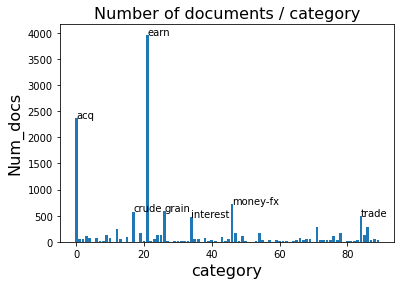

In [6]:
# make new dataframe from rows which num_docs >= 400 to annotate
df = data.query('Num_docs >= 400')

# bar plot with matplotlib in Python
plt.bar(data.index, data.Num_docs, alpha=1)   

# iterate through index
for i in df.index:                                      
    plt.annotate(data.iloc[i,0], (i,data.iloc[i,1]))    # add categories names to datapoints which are >= 400

# set x-axis label and specific size
plt.xlabel('category',size=16)                          
# set y-axis label and specific size
plt.ylabel('Num_docs',size=16)
# set plot title with specific size
plt.title('Number of documents / category',size=16)
# save the plot as PNG file with dpi=150
#plt.savefig('docs_per_category.png', dpi=150)
plt.show()

# 2. Construct the feature set using CountVectorizer of the training dataset so that the maximum size of the feature set is 100 and each word feature should be contained in at least 3 documents and in less than 70% of total documents to be considered. Use standard preprocessing and stopword list, with WordNet lemmatizer.

## Preprosessor

In [88]:
#(not used)

def preProcess_words(doc):
    wnl = WordNetLemmatizer()
    # Lemmatize all words from document and make list of them
    words_lemma = [wnl.lemmatize(word.lower(), pos="v") for word in doc]
    # iterate through punctuations
    for punct in punctuation:
        # iterate through tokens in document (copy because removing items from original list)
        for token in words_lemma[:]:    
            try:
                # remove digits/numbers from list
                if token.isdigit():
                    words_lemma.remove(token)
                # remove stopwords from list
                if token in stopwords.words("english"):
                    words_lemma.remove(token)
                # remove punctuation from list
                words_lemma.remove(punct)
            except ValueError:
                continue
  
    return words_lemma

In [91]:
def preProcess_raw(doc):
    """Removes stopwords, punctuation, and digits. Also Tokenizes and Lemmatizes the text"""
    wnl = WordNetLemmatizer()

    doc = doc.lower() # make lower case
    stop_words = stopwords.words("english")

    # iterate through punctuations
    for punct in (punctuation + "\n"):
        doc = doc.replace(punct, "")    # remove punctuation
    
    #for stop in stopwords.words("english"):
    #    doc = doc.replace(stop, "")       # remove stopwords

    doc = word_tokenize(doc)    # tokenize


    for token in doc[:]:
        if token.isdigit():     # remove digits
            doc.remove(token)
        if token in stop_words:
            doc.remove(token)
    
    words_lemma = [wnl.lemmatize(word, pos="v") for word in doc]
  
    return words_lemma

In [9]:
preProcess_raw("I wanted to see, her in the 10293 , *")

['want', 'see']

In [10]:
preProcess_raw("I wanted to see, her in the 10293 , *")

['want', 'see']

## Make function to apply CountVectorizer

In [11]:
# Use class to define tokenizer that also applies WordNetLemmatizer to CountVectorizer
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

In [12]:
# define countVectrizer and fit

def BOW_model(train_data, test_data, max_features):
    """Return feature vectors from CounVectorizer"""
    BOW = CountVectorizer(#tokenizer=LemmaTokenizer(), 
                          #lowercase=True, 
                          max_features = max_features, 
                          stop_words = "english", 
                          min_df = 3, max_df = 0.7)
    # fit train data
    BOW.fit(train_data)
    BOW_train = BOW.transform(train_data)
    BOW_test = BOW.transform(test_data)
 
    #print(BOW.get_feature_names())
    return (BOW_train.toarray(), BOW_test.toarray())

## Extract data from reuters Dataset and divide to pre determined Training and Test variables

In [13]:
# select fileid
doc_list = np.array(reuters.fileids())

# create test and train IDs from documents
test_doc = doc_list[['test' in x for x in doc_list]]

train_doc = doc_list[['training' in x for x in doc_list]]

## Get labels ( categories ) for each document and create Dataframes

In [14]:

def create_df(data):
    """Create DataFrames to visualise data a bit and duplicate multi-categorial documents so that they have just one category but appear multiple times.
    - data: list of documents (e.g. train and test data)"""


    docs=[]

    for ids in tqdm(data, desc="processing documents"):
        cats = reuters.categories(ids)      # At each iteration we retrieve categories of an id
        #doc = reuters.words(ids)
        #doc = preProcess_words(doc)
        doc = reuters.raw(ids)
        doc = preProcess_raw(doc)
        doc_join = " ".join(doc)
        for cat in cats:
            docs.append([doc_join, doc, cat, ids]) # These documents are appended as a tuple (document, category, ids) in the list, iterate as many times as there is unique categories
    
    # docs=[(" ".join(reuters.words(ids)), cat, ids) for ids in train_doc for cat in reuters.categories(ids)] # list comprehension for loop

    df=pd.DataFrame(docs, columns=["document",'words_list', 'category','ids']) # The data frame is created using the generated tuple.

    #df # check dataframe
    return df

# train_df["ids"].duplicated().value_counts() # checks how many duplicates because of categories


In [15]:
train_df = create_df(train_doc)
train_df

processing documents:   0%|          | 0/7769 [00:00<?, ?it/s]

,document,words_list,category,ids
0,bahia cocoa review shower continue throughout ...,"[bahia, cocoa, review, shower, continue, throu...",cocoa,training/1
1,computer terminal systems ltcpml complete sale...,"[computer, terminal, systems, ltcpml, complete...",acq,training/10
2,nz trade bank deposit growth rise slightly new...,"[nz, trade, bank, deposit, growth, rise, sligh...",money-supply,training/100
3,national amusements up viacom ltvia bid viacom...,"[national, amusements, up, viacom, ltvia, bid,...",acq,training/1000
4,rogers ltrog see 1st qtr net significantly rog...,"[rogers, ltrog, see, 1st, qtr, net, significan...",earn,training/10000
...,...,...,...,...
9579,uk money market shortage forecast revise bank ...,"[uk, money, market, shortage, forecast, revise...",money-fx,training/999
9580,knightridder inc ltkrn set quarterly qtly div ...,"[knightridder, inc, ltkrn, set, quarterly, qtl...",earn,training/9992
9581,technitrol inc lttnl set quarterly qtly div ct...,"[technitrol, inc, lttnl, set, quarterly, qtly,...",earn,training/9993
9582,nationwide cellular service inc ltncel 4th qtr...,"[nationwide, cellular, service, inc, ltncel, 4...",earn,training/9994


In [16]:
test_df = create_df(test_doc)
test_df

processing documents:   0%|          | 0/3019 [00:00<?, ?it/s]

,document,words_list,category,ids
0,asian exporters fear damage usjapan rift mount...,"[asian, exporters, fear, damage, usjapan, rift...",trade,test/14826
1,china daily say vermin eat pct grain stock sur...,"[china, daily, say, vermin, eat, pct, grain, s...",grain,test/14828
2,japan revise longterm energy demand downwards ...,"[japan, revise, longterm, energy, demand, down...",crude,test/14829
3,japan revise longterm energy demand downwards ...,"[japan, revise, longterm, energy, demand, down...",nat-gas,test/14829
4,thai trade deficit widen first quarter thailan...,"[thai, trade, deficit, widen, first, quarter, ...",corn,test/14832
...,...,...,...,...
3739,tokyo dealers see dollar poise breach yen toky...,"[tokyo, dealers, see, dollar, poise, breach, y...",money-fx,test/21573
3740,tokyo dealers see dollar poise breach yen toky...,"[tokyo, dealers, see, dollar, poise, breach, y...",yen,test/21573
3741,japanindia conference cut gulf war risk charge...,"[japanindia, conference, cut, gulf, war, risk,...",ship,test/21574
3742,soviet industrial growthtrade slower soviet un...,"[soviet, industrial, growthtrade, slower, sovi...",ipi,test/21575


In [17]:
# Save data as csv

with open('./train_data.csv', 'a' ,encoding='utf-8') as csvFile:
        train_df.to_csv(csvFile, mode='a', index=False, encoding="utf-8", sep=',')

with open('./test_data.csv', 'a' ,encoding='utf-8') as csvFile:
        test_df.to_csv(csvFile, mode='a', index=False, encoding="utf-8", sep=',')

## Get Feature vectors from documents

In [18]:
features_train, features_test = BOW_model(train_df["document"], test_df["document"], 100)

In [19]:
print(features_train)

[[0 0 0 ... 2 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 2 0 0]
 ...
 [0 0 2 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 1 0 0]]


# 3. Use NaivesBayes classifier to generate the model and test it on the testing dataset. Output the accuracy and F1 measure of this classifier. Compare the result with Random Forest and linear SVM classifiers.


## NaiveBayes Classifier

In [20]:
# Create a Gaussian NaiveBayes Classifier
gnb = GaussianNB()

# Create a Multinomial NaiveBayes Classifier
mnb = MultinomialNB()

# Create a Complement NaiveBayes Classifier
cnb = ComplementNB()


In [21]:
# Fit/train the NaiveBayes model
classifier = gnb.fit(features_train, train_df["category"])
#classifier = nltk.NaiveBayesClassifier.train(train_df["category"], features_train)
#?nltk.NaiveBayesClassifier

In [22]:
# Make predictions
expected = test_df["category"]
predicted = classifier.predict(features_test)

In [23]:
# Output the accuracy and F1 measure of this classifier
print("accuracy = ", metrics.accuracy_score(expected, predicted))
accuracy_nb = metrics.accuracy_score(expected, predicted)
print("f1 score = ", metrics.f1_score(expected, predicted, average = "weighted"))
f1_nb = metrics.f1_score(expected, predicted, average = "weighted")

accuracy =  0.30448717948717946
f1 score =  0.33880901542438574


In [24]:
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

                 precision    recall  f1-score   support

            acq       0.91      0.10      0.17       719
           alum       0.08      0.04      0.06        23
         barley       0.02      0.07      0.03        14
            bop       0.60      0.10      0.17        30
        carcass       0.07      0.11      0.09        18
     castor-oil       0.00      0.00      0.00         1
          cocoa       0.45      0.28      0.34        18
        coconut       0.00      0.00      0.00         2
    coconut-oil       0.00      0.00      0.00         3
         coffee       0.14      0.04      0.06        28
         copper       0.00      0.00      0.00        18
     copra-cake       0.00      0.00      0.00         1
           corn       0.25      0.02      0.03        56
         cotton       0.00      0.00      0.00        20
     cotton-oil       0.00      0.00      0.00         2
            cpi       0.33      0.04      0.06        28
            cpu       0.02    

C:\Users\Joonas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Joonas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Joonas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

## RandomForestClassifier

In [25]:
# Create RandomForestClassifier
rfc = RandomForestClassifier() # n_estimators=100, random_state=0

# Train RFC model
RFC_classifier = rfc.fit(features_train, train_df["category"])

In [26]:
predicted = RFC_classifier.predict(features_test)
expected = test_df["category"]
#print(metrics.classification_report(expected, predicted))
#print(metrics.confusion_matrix(expected, predicted))

In [27]:
# Output the accuracy and F1 measure of this classifier
print("accuracy = ", metrics.accuracy_score(expected, predicted))
accuracy_rf = metrics.accuracy_score(expected, predicted)
print("f1 score = ", metrics.f1_score(expected, predicted, average = "weighted"))
f1_rf = metrics.f1_score(expected, predicted, average = "weighted")


accuracy =  0.6530448717948718
f1 score =  0.6068987852543831


##  Linear SVM classifier

In [28]:
# Create SVM Classifier
#svm = SVC(kernel="linear")
svm = LinearSVC()

# Train SVM model
SVM_classifier = svm.fit(features_train, train_df["category"])

C:\Users\Joonas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [29]:
predicted = SVM_classifier.predict(features_test)
expected = test_df["category"]

# Output the accuracy and F1 measure of this classifier
print("accuracy = ", metrics.accuracy_score(expected, predicted))
accuracy_svm = metrics.accuracy_score(expected, predicted)
print("f1 score = ", metrics.f1_score(expected, predicted, average = "weighted"))
f1_svm = metrics.f1_score(expected, predicted, average = "weighted")

accuracy =  0.6292735042735043
f1 score =  0.5865778862208332


In [30]:
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

                 precision    recall  f1-score   support

            acq       0.69      0.94      0.80       719
           alum       0.10      0.04      0.06        23
         barley       0.15      0.14      0.15        14
            bop       0.61      0.37      0.46        30
        carcass       0.00      0.00      0.00        18
     castor-oil       0.00      0.00      0.00         1
          cocoa       0.33      0.39      0.36        18
        coconut       0.00      0.00      0.00         2
    coconut-oil       0.00      0.00      0.00         3
         coffee       0.26      0.25      0.25        28
         copper       0.14      0.06      0.08        18
     copra-cake       0.00      0.00      0.00         1
           corn       0.33      0.29      0.30        56
         cotton       0.00      0.00      0.00        20
     cotton-oil       0.00      0.00      0.00         2
            cpi       0.26      0.18      0.21        28
            cpu       0.00    

C:\Users\Joonas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Joonas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Joonas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

## List results

In [31]:
results_100 = [(accuracy_nb, f1_nb), (accuracy_rf, f1_rf), (accuracy_svm, f1_svm)]
results_100_df = pd.DataFrame(results_100, columns=['acc', 'f1'], index=["nb","rf", "svm"])
results_100_df

,acc,f1
nb,0.304487,0.338809
rf,0.653045,0.606899
svm,0.629274,0.586578


# 4. Show the results of this classifier when the total number of features varies as 1000, 1500, 2000, 2500, 3000, 3500, 4500, 5000.

## Create function to apply classifier

In [202]:
# funtion to apply NaiveBayes classifier, print and return accuracy and f1-value

def nb_classifier(features_train,features_test, **kwargs):
    """ funtion to apply NaiveBayes classifier, print and return accuracy and f1-value 
    :param conf: get confusion matrix
    :param label_t: alternate training labels, default train_df["category"]
    :param label: alternate testing labels, default test_df["category"]
    """

    conf = kwargs.get("conf", False)
    label_t = kwargs.get("label_t", train_df["category"])
    label = kwargs.get("label", test_df["category"])

    # Fit/train the gaussian NaiveBayes model
    classifier = gnb.fit(features_train, label_t)

    # Make predictions
    expected = label
    predicted = classifier.predict(features_test)

    # summarize the fit of the model
    #print(metrics.classification_report(expected, predicted))
    cm = metrics.confusion_matrix(expected, predicted)
    #print("Confusion matrix: \n", cm)
    #print("confusion matrix shape: ", cm.shape)

    ##Output the accuracy and F1 measure of this classifier
    accuracy_nb = metrics.accuracy_score(expected, predicted)
    print("accuracy: ", accuracy_nb)
    f1_nb = metrics.f1_score(expected, predicted, average = "weighted")
    print("f1 score: ", f1_nb)

    if conf is True:
        return (accuracy_nb, f1_nb, cm)
    else:
        return (accuracy_nb, f1_nb)



In [265]:
def rf_classifier(features_train,features_test, **kwargs):
    """ funtion to apply RandomForest classifier, print and return accuracy and f1-value 
    :param conf: get confusion matrix
    :param label_t: alternate training labels, default train_df["category"]
    :param label: alternate testing labels, default test_df["category"]
    """

    conf = kwargs.get("conf", False)
    label_t = kwargs.get("label_t", train_df["category"])
    label = kwargs.get("label", test_df["category"])

    # Create RandomForestClassifier
    rfc = RandomForestClassifier()

    # Train RFC model
    classifier = rfc.fit(features_train, label_t)

    # make predictions
    predicted = classifier.predict(features_test)
    expected = label

    # summarize the fit of the model
    #print(metrics.classification_report(expected, predicted))
    #print(metrics.confusion_matrix(expected, predicted))

    # Output the accuracy and F1 measure of this classifier
    print("accuracy = ", metrics.accuracy_score(expected, predicted))
    accuracy_rf = metrics.accuracy_score(expected, predicted)
    print("f1 score = ", metrics.f1_score(expected, predicted, average = "weighted"))
    f1_rf = metrics.f1_score(expected, predicted, average = "weighted")

    return (accuracy_rf, f1_rf)

In [267]:
def svm_classifier(features_train,features_test, **kwargs):
    """ funtion to apply Linear SVM classifier, print and return accuracy and f1-value 
    :param conf: get confusion matrix
    :param label_t: alternate training labels, default train_df["category"]
    :param label: alternate testing labels, default test_df["category"]
    """

    conf = kwargs.get("conf", False)
    label_t = kwargs.get("label_t", train_df["category"])
    label = kwargs.get("label", test_df["category"])

    # Get feature vectors
    #BOW_train = BOW_model(train_df["document"], features)
    #BOW_test = BOW_model(test_df["document"], features)

    # Create SVM Classifier
    #svm = SVC(kernel="linear")
    svm = LinearSVC()

    # Train SVM model
    classifier = svm.fit(features_train, label_t)
    predicted = classifier.predict(features_test)
    expected = label

    # summarize the fit of the model
    #print(metrics.classification_report(expected, predicted))
    #print(metrics.confusion_matrix(expected, predicted))

    # Output the accuracy and F1 measure of this classifier
    print("accuracy = ", metrics.accuracy_score(expected, predicted))
    accuracy_svm = metrics.accuracy_score(expected, predicted)
    print("f1 score = ", metrics.f1_score(expected, predicted, average = "weighted"))
    f1_svm = metrics.f1_score(expected, predicted, average = "weighted")

    return (accuracy_svm, f1_svm)


## Apply function

### BOW models

In [549]:
# use all numbers of vectors
num_vec = [100,1000,1500,2000,2500,3000,3500,4500,5000]
# list for feature vectors
feature_vecs = []

# iterate through numbers
for num in num_vec:
   # make feature vectors as tuples (train, test) and append to list
   feature_vecs.append(BOW_model(train_df["document"], test_df["document"], num))

   

### NaiveBayes

In [550]:
# add results list
results = []

# iterate through feature vectors
for vec in feature_vecs:
    # apply classifier and append results to list: train = 0 , test = 1
    results.append(nb_classifier(vec[0],vec[1]))
    #print(vec[1])

nb_results_df = pd.DataFrame(results, columns=['acc', 'f1'], index=["nb_100", "nb_1000", "nb_1500", "nb_2000", "nb_2500", "nb_3000", "nb_3500", "nb_4500", "nb_5000"])


accuracy:  0.30448717948717946
f1 score:  0.33880901542438574
accuracy:  0.46287393162393164
f1 score:  0.4780324797902941
accuracy:  0.47275641025641024
f1 score:  0.47364938943962137
accuracy:  0.48691239316239315
f1 score:  0.4791069624977836
accuracy:  0.4935897435897436
f1 score:  0.48073539414783034
accuracy:  0.4965277777777778
f1 score:  0.47957790932911787
accuracy:  0.5032051282051282
f1 score:  0.4819365143559217
accuracy:  0.5173611111111112
f1 score:  0.49538867829719857
accuracy:  0.5205662393162394
f1 score:  0.496727538502165


In [37]:
nb_results_df

,acc,f1
nb_100,0.304487,0.338809
nb_1000,0.462874,0.478032
nb_1500,0.472756,0.473649
nb_2000,0.486912,0.479107
nb_2500,0.493590,0.480735
nb_3000,0.496528,0.479578
nb_3500,0.503205,0.481937
nb_4500,0.517361,0.495389
nb_5000,0.520566,0.496728


<AxesSubplot:>

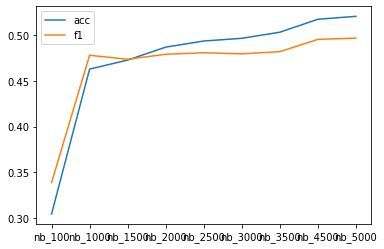

In [38]:
nb_results_df.plot()

### Random Forest

In [39]:
results = []

for vec in feature_vecs:
    results.append(rf_classifier(vec[0],vec[1]))
    #print(results)

rf_results_df = pd.DataFrame(results, columns=['acc', 'f1'], index=["rf_100", "rf_1000", "rf_1500", "rf_2000", "rf_2500", "rf_3000", "rf_3500", "rf_4500", "rf_5000"])


accuracy =  0.655715811965812
f1 score =  0.6064032819812969
accuracy =  0.7104700854700855
f1 score =  0.666033045410702
accuracy =  0.7069978632478633
f1 score =  0.6644490189995013
accuracy =  0.7061965811965812
f1 score =  0.6614511093754899
accuracy =  0.7069978632478633
f1 score =  0.6645116541164949
accuracy =  0.6992521367521367
f1 score =  0.6524031309617795
accuracy =  0.7032585470085471
f1 score =  0.6574366486940839
accuracy =  0.7040598290598291
f1 score =  0.6574803496468625
accuracy =  0.6987179487179487
f1 score =  0.6521105861458618


<AxesSubplot:>

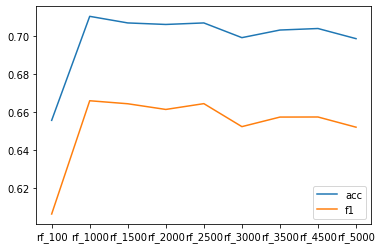

In [40]:
rf_results_df.plot()

### SVM

In [41]:
results = []

for vec in feature_vecs:
    results.append(svm_classifier(vec[0],vec[1]))
    #print(results)

svm_results_df = pd.DataFrame(results, columns=['acc', 'f1'], index=["svm_100", "svm_1000", "svm_1500", "svm_2000", "svm_2500", "svm_3000", "svm_3500", "svm_4500", "svm_5000"])


C:\Users\Joonas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


accuracy =  0.6274038461538461
f1 score =  0.5846717326424811


C:\Users\Joonas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


accuracy =  0.7011217948717948
f1 score =  0.6882717188633408


C:\Users\Joonas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


accuracy =  0.7096688034188035
f1 score =  0.6956370115780907


C:\Users\Joonas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


accuracy =  0.7155448717948718
f1 score =  0.7025223751186921


C:\Users\Joonas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


accuracy =  0.7230235042735043
f1 score =  0.710901611600447


C:\Users\Joonas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


accuracy =  0.7224893162393162
f1 score =  0.7088108894291214


C:\Users\Joonas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


accuracy =  0.7227564102564102
f1 score =  0.7097985990850144


C:\Users\Joonas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


accuracy =  0.7243589743589743
f1 score =  0.7098064078880867
accuracy =  0.7232905982905983
f1 score =  0.7087869856182579


C:\Users\Joonas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


<AxesSubplot:>

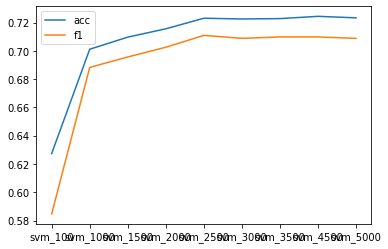

In [42]:
svm_results_df.plot()

## List Results

In [43]:
results_df = pd.DataFrame()
results_df = results_df.append(nb_results_df)
results_df = results_df.append(rf_results_df)
results_df = results_df.append(svm_results_df)
results_df

,acc,f1
nb_100,0.304487,0.338809
nb_1000,0.462874,0.478032
nb_1500,0.472756,0.473649
nb_2000,0.486912,0.479107
nb_2500,0.493590,0.480735
nb_3000,0.496528,0.479578
nb_3500,0.503205,0.481937
nb_4500,0.517361,0.495389
nb_5000,0.520566,0.496728
rf_100,0.655716,0.606403


# 5. Repeat 3) when a PCA (of 95% information preservation) is used to reduce the dimension of the feature space. 


## PCA function

In [44]:
def PCA_apply (features_train, features_test):
    # use principal component analysis with 95% info preservation
    pca = PCA(n_components=0.95)
    # fit training vectors
    pca.fit(features_train)
    # transform
    pca_train = pca.transform(features_train)
    pca_test = pca.transform(features_test)
    return pca_train, pca_test

In [45]:
# call pca funcion
pca_train, pca_test = PCA_apply(features_train, features_test)

## NaiveBayes with PCA

In [46]:
# make list of classifier tuples and create dataframe
score_nb_pca = [nb_classifier(pca_train, pca_test)]
pca_df = pd.DataFrame(score_nb_pca, columns=['acc', 'f1'], index=["nb_100"])

[[447   1   0 ...   0   0   0]
 [  4   0   0 ...   0   0   0]
 [  2   1   1 ...   0   0   0]
 ...
 [  1   0   0 ...   1   0   0]
 [  3   0   0 ...   0   8   0]
 [  0   2   0 ...   0   0   1]]
(90, 90)
accuracy:  0.4321581196581197
f1 score:  0.44096725345692794


## RandomForest With PCA

In [47]:
# make list of classifier tuples and create dataframe
score_rf_pca = [rf_classifier(pca_train, pca_test)]
pca_rf = pd.DataFrame(score_rf_pca, columns=['acc', 'f1'], index=["rf_100"])

accuracy =  0.6324786324786325
f1 score =  0.5716317786835456


## Linear SVM with PCA

In [48]:
# make list of classifier tuples and create dataframe
score_svm_pca = [svm_classifier(pca_train, pca_test)]
pca_svm = pd.DataFrame(score_svm_pca, columns=['acc', 'f1'], index=["svm_100"])

accuracy =  0.6327457264957265
f1 score =  0.5852950652606027


C:\Users\Joonas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [49]:
pca_df = pca_df.append(pca_rf)
pca_df = pca_df.append(pca_svm)
pca_df

,acc,f1
nb_100,0.432158,0.440967
rf_100,0.632479,0.571632
svm_100,0.632746,0.585295


# 6. Instead of CountVectorizer, use TfidfVectorizer to create the feature set as in 2) and test the classification accuracy and F1 measure of Naives’ Bayes classifier.


In [50]:
def tfidf_model(train_data, test_data, max_features):
    """Return feature vectors from tfidfVectorizer"""
    tfidf = TfidfVectorizer(tokenizer=LemmaTokenizer(), 
                          lowercase=True, 
                          max_features = max_features, 
                          stop_words = "english", 
                          min_df = 3, max_df = 0.7)
    # fit train data
    tfidf.fit(train_data)
    tfidf_train = tfidf.transform(train_data)
    tfidf_test = tfidf.transform(test_data)
 
    #print(tfidf.get_feature_names())
    return (tfidf_train.toarray(), tfidf_test.toarray())

In [51]:
tfidf_feature_train, tfidf_feature_test = tfidf_model(train_df['document'], test_df['document'], 100)

C:\Users\Joonas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
C:\Users\Joonas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [52]:
tfidf_accuracy, tfidf_f1 = nb_classifier(tfidf_feature_train, tfidf_feature_test)

[[99 14  5 ...  0  0 61]
 [ 0  1  0 ...  0  0  1]
 [ 0  0  5 ...  0  0  0]
 ...
 [ 0  0  0 ...  3  0  0]
 [ 0  0  0 ...  0  5  0]
 [ 0  0  0 ...  0  0  1]]
(90, 90)
accuracy:  0.3370726495726496
f1 score:  0.3711534329052627


# 7. Use Word2vec to create a feature vector to each document by averaging over all word2vec representations of individual words constituting the document. Use this feature set to train the Naives’ Bayes classifier and output the accuracy, F1 measure and confusion matrix on testing data. 


USE WORDS INSTEAD OF LONG STRINGS!

In [53]:
import multiprocessing
import logging
import sys

workers = multiprocessing.cpu_count()
print('number of cpu: {}'.format(workers))

number of cpu: 12


## Word2Vec - functions

In [54]:
def Train_Embedding(train, val, test, method=''):
    train_tokens, val_tokens, test_tokens = [], [], []
    
    for text in train:
        train_tokens.append(text.split())
    for text in val:
        val_tokens.append(text.split())
    for text in test:
        test_tokens.append(text.split())

    if method == 'word2vec':
        model= Word2Vec(train_tokens+val_tokens+test_tokens, min_count=1, window=10,  workers=workers, vector_size=300, epochs=100)
        #model.save('./reuters_W2Vec.bin')
    return model



In [66]:

class MeanEmbeddingVectorizer(object):

	def __init__(self, word_model):
		self.word_model = word_model
		self.vector_size = word_model.vector_size

	def fit(self):  # comply with scikit-learn transformer requirement
		return self

	def transform(self, docs):  # comply with scikit-learn transformer requirement
		doc_word_vector = self.word_average_list(docs)
		return doc_word_vector

	def word_average(self, sent):
		"""
		Compute average word vector for a single doc/sentence.
		:param sent: list of sentence tokens
		:return:
			mean: float of averaging word vectors
		"""
		mean = []
		for word in sent:
			if word in self.word_model.key_to_index:
				mean.append(self.word_model.get_vector(word))

		if not mean:  # empty words
			# If a text is empty, return a vector of zeros.
			logging.warning("cannot compute average owing to no vector for {}".format(sent))
			return np.zeros(self.vector_size)
		else:
			mean = np.array(mean).mean(axis=0)
			return mean


	def word_average_list(self, docs):
		"""
		Compute average word vector for multiple docs, where docs had been tokenized.
		:param docs: list of sentence in list of separated tokens
		:return:
			array of average word vector in shape (len(docs),)
		"""
		return np.vstack([self.word_average(sent) for sent in docs])

In [340]:
def Text_embedding(model, Texts):
    Texts_embed = []
    words = list(model.wv.key_to_index)
    for text in tqdm(Texts, desc="Embedding mean vectors for documents"):
        text_embed = [0]
        for word in text.split():         
            if word in words:    
                text_embed = np.add(text_embed, model.wv[word])
            else:
                words_not_found.append(word)
        text_embed = np.divide(text_embed, len(text.split()))

        #    text_embed = np.add(text_embed, model.wv[word])
        #text_embed = np.divide(text_embed, len(text.split()))   # averaging
        Texts_embed.append(text_embed)
    return Texts_embed


## Word2Vec - Train

In [57]:
# join dataframes into one
w2v_train_df = pd.DataFrame()
w2v_train_df = w2v_train_df.append(train_df)
w2v_train_df = w2v_train_df.append(test_df)
w2v_train_df

,document,words_list,category,ids
0,bahia cocoa review shower continue throughout ...,"[bahia, cocoa, review, shower, continue, throu...",cocoa,training/1
1,computer terminal systems ltcpml complete sale...,"[computer, terminal, systems, ltcpml, complete...",acq,training/10
2,nz trade bank deposit growth rise slightly new...,"[nz, trade, bank, deposit, growth, rise, sligh...",money-supply,training/100
3,national amusements up viacom ltvia bid viacom...,"[national, amusements, up, viacom, ltvia, bid,...",acq,training/1000
4,rogers ltrog see 1st qtr net significantly rog...,"[rogers, ltrog, see, 1st, qtr, net, significan...",earn,training/10000
...,...,...,...,...
3739,tokyo dealers see dollar poise breach yen toky...,"[tokyo, dealers, see, dollar, poise, breach, y...",money-fx,test/21573
3740,tokyo dealers see dollar poise breach yen toky...,"[tokyo, dealers, see, dollar, poise, breach, y...",yen,test/21573
3741,japanindia conference cut gulf war risk charge...,"[japanindia, conference, cut, gulf, war, risk,...",ship,test/21574
3742,soviet industrial growthtrade slower soviet un...,"[soviet, industrial, growthtrade, slower, sovi...",ipi,test/21575


In [58]:
# init and train word2vec model

model_own= Word2Vec(train_df["words_list"], min_count=1, window=10,  workers=workers, vector_size=100, epochs=100) ##, iter=1000)

#model.save('./reuters_W2Vec.bin')


In [59]:
model = Word2Vec(w2v_train_df["words_list"], min_count=1, window=10,  workers=workers, vector_size=100, epochs=100)

## Word2Vec - Mean vector

In [342]:
mean_vec_train = Text_embedding(model, train_df["document"])

Embedding mean vectors for documents:   0%|          | 0/9584 [00:00<?, ?it/s]

In [343]:
mean_vec_test = Text_embedding(model, test_df["document"])

Embedding mean vectors for documents:   0%|          | 0/3744 [00:00<?, ?it/s]

In [345]:
#mean_vec_tr = MeanEmbeddingVectorizer(model3)
#doc_vec_train = mean_vec_tr.transform(train_df["document"])
#doc_vec_test = mean_vec_tr.transform(test_df["document"])


In [346]:
#doc_vec_train

## Word2Vec - Load pre-trained model

In [62]:
import gensim.downloader as api
print(list(api.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [63]:
model3 = api.load("word2vec-google-news-300")

## Word2Vec - NaiveBayes

In [344]:
acc,f1,conf_matrix = nb_classifier(mean_vec_train,mean_vec_test,conf=True)
print(conf_matrix)

accuracy:  0.6458333333333334
f1 score:  0.6522030599697342
[[683   1   0 ...   0   0   0]
 [  0   8   0 ...   0   0   0]
 [  0   0   5 ...   0   0   0]
 ...
 [  0   0   0 ...   7   0   0]
 [  0   0   0 ...   0   9   0]
 [  0   2   0 ...   0   0   1]]


# 8. Now we would like to tackle the discrepancy of the number of instances in training data among the various categories. For this purpose, create a new partition, where you remove the categories that contains very large number of instances and very low number of instances as compared to the rest of the categories. Repeat 3) and provide the results on the table. 

## Remove categories with very large/low instanses

In [659]:
def remove_categories(data, lower, upper):
    """Remove categories outside treshold values. Return dataframe.
    :param lower: lower limit, type: int
    :param upper: upper limit, type: int
    :param data: pd.Dataframe
    """
    
    # get count of documents/category
    data_counts = data.groupby(["category"]).count().sort_values("document")
    # make dataframe wherecategory is index
    df = data.set_index("category")
    # loop for catching the category names with unwanted categories with 10 < doc < 1000
    for category in data_counts.index:  # here index is category
        # get count of documents in this category
        doc_count = data_counts.loc[category, "document"]
        # if docs count not between tresholds, drop category
        if not lower <= doc_count <= upper:
            df=df.drop(index=category)

    #print(f"Removed {len(category_names)} categories")

    return df.reset_index()
#count

In [222]:
# set max rows displayed for pandas
pd.set_option('display.max_rows', 90)

In [587]:
# unify data to make new partition
data=train_df.append(test_df).reset_index(drop=True)
data

,document,words_list,category,ids
0,bahia cocoa review shower continue throughout ...,"[bahia, cocoa, review, shower, continue, throu...",cocoa,training/1
1,computer terminal systems ltcpml complete sale...,"[computer, terminal, systems, ltcpml, complete...",acq,training/10
2,nz trade bank deposit growth rise slightly new...,"[nz, trade, bank, deposit, growth, rise, sligh...",money-supply,training/100
3,national amusements up viacom ltvia bid viacom...,"[national, amusements, up, viacom, ltvia, bid,...",acq,training/1000
4,rogers ltrog see 1st qtr net significantly rog...,"[rogers, ltrog, see, 1st, qtr, net, significan...",earn,training/10000
...,...,...,...,...
13323,tokyo dealers see dollar poise breach yen toky...,"[tokyo, dealers, see, dollar, poise, breach, y...",money-fx,test/21573
13324,tokyo dealers see dollar poise breach yen toky...,"[tokyo, dealers, see, dollar, poise, breach, y...",yen,test/21573
13325,japanindia conference cut gulf war risk charge...,"[japanindia, conference, cut, gulf, war, risk,...",ship,test/21574
13326,soviet industrial growthtrade slower soviet un...,"[soviet, industrial, growthtrade, slower, sovi...",ipi,test/21575


In [651]:
# unified dataset remove categories
data_minmax = remove_categories(data,10,1000)
data_minmax

,category,document,words_list,ids
0,cocoa,bahia cocoa review shower continue throughout ...,"[bahia, cocoa, review, shower, continue, throu...",training/1
1,money-supply,nz trade bank deposit growth rise slightly new...,"[nz, trade, bank, deposit, growth, rise, sligh...",training/100
2,trade,uk grow impatient japan thatcher prime ministe...,"[uk, grow, impatient, japan, thatcher, prime, ...",training/10005
3,crude,canada oil export rise pct canadian oil export...,"[canada, oil, export, rise, pct, canadian, oil...",training/10011
4,nat-gas,canada oil export rise pct canadian oil export...,"[canada, oil, export, rise, pct, canadian, oil...",training/10011
...,...,...,...,...
6868,money-fx,tokyo dealers see dollar poise breach yen toky...,"[tokyo, dealers, see, dollar, poise, breach, y...",test/21573
6869,yen,tokyo dealers see dollar poise breach yen toky...,"[tokyo, dealers, see, dollar, poise, breach, y...",test/21573
6870,ship,japanindia conference cut gulf war risk charge...,"[japanindia, conference, cut, gulf, war, risk,...",test/21574
6871,ipi,soviet industrial growthtrade slower soviet un...,"[soviet, industrial, growthtrade, slower, sovi...",test/21575


## Partition new data to train and test set

In [652]:
data_train, data_test = train_test_split(data_minmax, test_size=0.3, random_state=42)

## Feature vectors with CountVectorizer

In [653]:
# With unified and self partiotioned data 
features_train_up, features_test_up = BOW_model(data_train["document"], data_test["document"], 100)

## Naive Bayes

In [654]:
# With unified and self partiotioned data 
results_nb = nb_classifier(features_train_up, features_test_up, label_t=data_train["category"], label=data_test["category"])

accuracy:  0.0863239573229874
f1 score:  0.09300217101412202


## RandomForest

In [655]:
# With unified and self partiotioned data 
results_rf = rf_classifier(features_train_up, features_test_up, label_t=data_train["category"], label=data_test["category"])

accuracy =  0.3516003879728419
f1 score =  0.34131499902506085


## Linear SVM

In [657]:
# With unified and self partiotioned data 
results_svm = svm_classifier(features_train_up, features_test_up, label_t=data_train["category"], label=data_test["category"])

accuracy =  0.38118331716779824
f1 score =  0.36555796518659867


C:\Users\Joonas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


## Results on a table

In [658]:
results_100 = [results_nb, results_rf, results_svm]
results_100_df = pd.DataFrame(results_100, columns=['acc', 'f1'], index=["nb","rf", "svm"])
results_100_df

,acc,f1
nb,0.086324,0.093002
rf,0.351600,0.341315
svm,0.381183,0.365558


# 9. Similarly, use word2vec model to calculate the new performance on the testing data for the new set of categories in 8).

In [660]:
mean_vec_train_minmax = Text_embedding(model, data_train["document"])
mean_vec_test_mimax = Text_embedding(model, data_test["document"])

Embedding mean vectors for documents:   0%|          | 0/4811 [00:00<?, ?it/s]

Embedding mean vectors for documents:   0%|          | 0/2062 [00:00<?, ?it/s]

In [661]:
nb_classifier(mean_vec_train_minmax, mean_vec_test_mimax, label_t=data_train["category"], label=data_test["category"])

accuracy:  0.4354995150339476
f1 score:  0.4340809647562578


(0.4354995150339476, 0.4340809647562578)

In [372]:
#mean_vec_train_minmax = Text_embedding(model, train_df_minmax["document"])
#mean_vec_test_mimax = Text_embedding(model, test_df["document"])

In [373]:
#nb_classifier(mean_vec_train_minmax, mean_vec_test_mimax, label_t=train_df_minmax["category"], label=test_df["category"])

# 10. Now we would like to handle the data discrepancy in the class, we would like to perform data augmentation on the small size classes. For this purpose, for the classes, which contain small number of instances, write a script that allows you to duplicate the number of small samples at an order close to the average of other classes. Then repeat the process 3) and test whether an enhancement of the results on the testing data can be noticed.
 

## Augment classes in dataset

In [543]:
def augment_lower_categories(data):
    """Augment categories under treshold values. Return dataframe.
    :param data: pd.Dataframe
    """

    # get counts of documents/category
    data_counts = data.groupby(["category"]).count().sort_values("document")
    # get mean count of documents in dataset
    data_mean = int(data_counts["document"].mean())

    # iterate through categeories (here index is category)
    for category in tqdm(data_counts.index):
        doc_count = data_counts.loc[category, "document"]
        #print(doc_count)
        if doc_count < data_mean:
            # append category to list if count of docs is smaller than treshold
            for idx, index in enumerate(itertools.cycle(data[data['category'].isin([category])].index)):  # get index of the docs from the category and cycle over that index.
                # append docs from category to end of the dataframe
                data=data.append(data.iloc[index],ignore_index=True)
                # update count of documents belonging to category
                cnt=data[data['category'].isin([category])]["document"].count()
                # test if count of documents is at mean count of documents in dataset then break loop
                if cnt >= data_mean:
                    break

    #print(f"Removed {len(category_names)} categories")


    return data.reset_index(drop=True)

In [534]:
data_augmented = augment_lower_categories(data)

  0%|          | 0/90 [00:00<?, ?it/s]

In [544]:
# augmented dataset to labels and docs
data_aug_labels = data_augmented.drop(columns=['document','ids','words_list'])
data_aug_documents = data_augmented.drop(columns=['category','ids','words_list'])

In [540]:
# sanity check
data_augmented.groupby(["category"]).count().sort_values("document")["document"]

category
lumber              148
propane             148
potato              148
platinum            148
pet-chem            148
palmkernel          148
palm-oil            148
palladium           148
orange              148
oat                 148
nzdlr               148
nkr                 148
nickel              148
nat-gas             148
naphtha             148
meal-feed           148
yen                 148
livestock           148
rand                148
lin-oil             148
rape-oil            148
reserves            148
wpi                 148
veg-oil             148
tin                 148
tea                 148
sunseed             148
sun-oil             148
sun-meal            148
strategic-metal     148
soybean             148
soy-oil             148
soy-meal            148
sorghum             148
silver              148
rye                 148
rubber              148
rice                148
retail              148
rapeseed            148
lei                 148
zinc   

## Partition data to training and testing sets

In [567]:
data_aug_train, data_aug_test = train_test_split(data_augmented, test_size=0.3, random_state=42)

## Feature vectors with CountVectorizer

In [568]:
features_train_aug, features_test_aug = BOW_model(data_aug_train["document"], data_aug_test["document"], 100)

## NaiveBayes

In [570]:
results_nb_aug = nb_classifier(features_train_aug, features_test_aug, label_t=data_aug_train["category"], label=data_aug_test["category"])

accuracy:  0.36421725239616615
f1 score:  0.33304141030636686


## RandomForest

In [662]:
results_rf_aug = rf_classifier(features_train_aug, features_test_aug, label_t=data_aug_train["category"], label=data_aug_test["category"])

accuracy =  0.7034839494903393
f1 score =  0.68864725609573


## Linear SVM

In [663]:
results_svm_aug = svm_classifier(features_train_aug, features_test_aug, label_t=data_aug_train["category"], label=data_aug_test["category"])

accuracy =  0.6418682488970029
f1 score =  0.6147089089255717


C:\Users\Joonas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


## List Results

In [666]:
results_aug = [results_nb_aug, results_rf_aug, results_svm_aug]
results_aug_df = pd.DataFrame(results_aug, columns=['acc', 'f1'], index=["nb","rf", "svm"])
results_aug_df

,acc,f1
nb,0.364217,0.333041
rf,0.703484,0.688647
svm,0.641868,0.614709


## Word2Vec

In [667]:
mean_vec_train_aug = Text_embedding(model, data_aug_train["document"])
mean_vec_test_aug = Text_embedding(model, data_aug_test["document"])

Embedding mean vectors for documents:   0%|          | 0/15336 [00:00<?, ?it/s]

Embedding mean vectors for documents:   0%|          | 0/6573 [00:00<?, ?it/s]

In [668]:
nb_classifier(mean_vec_train_aug, mean_vec_test_aug, label_t=data_aug_train["category"], label=data_aug_test["category"])

accuracy:  0.6274151833257264
f1 score:  0.6240878974652054


(0.6274151833257264, 0.6240878974652054)

# 11. Now we would like to test the influence of the multi-category documents on the classification. For this purpose, write a script, which scrutinizes the training set, so that every document, which is found to belong to more than one category in the training set is removed. Repeat 3) and word2vec model to evaluate the performance of the model on the test data, and discuss the contribution of this removal action. 

## Scrutinize Data

In [705]:

def create_scrutinizable_df(data):
    """Create DataFrame and leave multi-categorial documents so that they can be scrutinized (deleted).
    - data: list of documents (e.g. train and test data)"""


    docs=[]

    for ids in tqdm(data, desc="processing documents"):
        cats = reuters.categories(ids)      # At each iteration we retrieve categories of an id
        #doc = reuters.words(ids)
        #doc = preProcess_words(doc)
        doc = reuters.raw(ids)
        doc = preProcess_raw(doc)
        doc_join = " ".join(doc)
        docs.append([doc_join, doc, cats, ids])
        #for cat in cats:
        #    docs.append([doc_join, doc, cat, ids]) # These documents are appended as a tuple (document, category, ids) in the list, iterate as many times as there is unique categories
    
    # docs=[(" ".join(reuters.words(ids)), cat, ids) for ids in train_doc for cat in reuters.categories(ids)] # list comprehension for loop

    df=pd.DataFrame(docs, columns=["document",'words_list', 'category','ids']) # The data frame is created using the generated tuple.

    #df # check dataframe
    return df

# train_df["ids"].duplicated().value_counts() # checks how many duplicates because of categories

In [696]:
def remove_multi_categories(data):
    """Remove categories outside treshold values. Return dataframe.
    :param lower: lower limit, type: int
    :param upper: upper limit, type: int
    :param data: pd.Dataframe
    """
    
    # get count of documents/category
    #data_counts = data.groupby(["category"]).count().sort_values("document")
    # make dataframe wherecategory is index
    #df = data.set_index("category")

    # iterate category column
    for i, category in enumerate(data["category"]):
        # if categorys (list) lenght is more than 1 
        if len(category) > 1:
            # dropthat row
            data=data.drop(index=i)
        else:
            # remove list type from categories
            data["category"][i] = data["category"][i][0]

    return data.reset_index(drop=True)
#count

In [702]:
scrutinizable_data = create_scrutinizable_df(doc_list)

processing documents:   0%|          | 0/10788 [00:00<?, ?it/s]

In [703]:
scrutinizable_data

,document,words_list,category,ids
0,asian exporters fear damage usjapan rift mount...,"[asian, exporters, fear, damage, usjapan, rift...",[trade],test/14826
1,china daily say vermin eat pct grain stock sur...,"[china, daily, say, vermin, eat, pct, grain, s...",[grain],test/14828
2,japan revise longterm energy demand downwards ...,"[japan, revise, longterm, energy, demand, down...","[crude, nat-gas]",test/14829
3,thai trade deficit widen first quarter thailan...,"[thai, trade, deficit, widen, first, quarter, ...","[corn, grain, rice, rubber, sugar, tin, trade]",test/14832
4,indonesia see cpo price rise sharply indonesia...,"[indonesia, see, cpo, price, rise, sharply, in...","[palm-oil, veg-oil]",test/14833
...,...,...,...,...
10783,uk money market shortage forecast revise bank ...,"[uk, money, market, shortage, forecast, revise...","[interest, money-fx]",training/999
10784,knightridder inc ltkrn set quarterly qtly div ...,"[knightridder, inc, ltkrn, set, quarterly, qtl...",[earn],training/9992
10785,technitrol inc lttnl set quarterly qtly div ct...,"[technitrol, inc, lttnl, set, quarterly, qtly,...",[earn],training/9993
10786,nationwide cellular service inc ltncel 4th qtr...,"[nationwide, cellular, service, inc, ltncel, 4...",[earn],training/9994


In [704]:
scrutinized_data = remove_multi_categories(scrutinizable_data)

## Partition Data to train and test sets

In [706]:
data_scrut_train, data_scrut_test = train_test_split(scrutinized_data, test_size=0.3, random_state=42)

## Feature vectors with CountVectorizer

In [707]:
features_train_scrut, features_test_scrut = BOW_model(data_scrut_train["document"], data_scrut_test["document"], 100)

## Naive Bayes

In [708]:
results_nb_scrut = nb_classifier(features_train_scrut, features_test_scrut, label_t=data_scrut_train["category"], label=data_scrut_test["category"])

accuracy:  0.4745269286754003
f1 score:  0.5587269362329664


## Random Forest

In [709]:
results_rf_scrut = rf_classifier(features_train_scrut, features_test_scrut, label_t=data_scrut_train["category"], label=data_scrut_test["category"])

accuracy =  0.8508005822416302
f1 score =  0.8324475020402917


## Linear SVM

In [710]:
results_svm_scrut = svm_classifier(features_train_scrut, features_test_scrut, label_t=data_scrut_train["category"], label=data_scrut_test["category"])

accuracy =  0.8344250363901019
f1 score =  0.8234819178769586


C:\Users\Joonas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


## List Results

In [711]:
results_scrut = [results_nb_scrut, results_rf_scrut, results_svm_scrut]
results_scrut_df = pd.DataFrame(results_scrut, columns=['acc', 'f1'], index=["nb","rf", "svm"])
results_scrut_df

,acc,f1
nb,0.474527,0.558727
rf,0.850801,0.832448
svm,0.834425,0.823482


## Word2Vec

In [712]:
mean_vec_train_scrut = Text_embedding(model, data_scrut_train["document"])
mean_vec_test_scrut= Text_embedding(model, data_scrut_test["document"])

Embedding mean vectors for documents:   0%|          | 0/6412 [00:00<?, ?it/s]

Embedding mean vectors for documents:   0%|          | 0/2748 [00:00<?, ?it/s]

### NaiveBayes

In [717]:
results_nb_w2v = nb_classifier(mean_vec_train_scrut, mean_vec_test_scrut, label_t=data_scrut_train["category"], label=data_scrut_test["category"])

accuracy:  0.8220524017467249
f1 score:  0.8319780494811609


### RandomForest

In [718]:
results_rf_w2v = rf_classifier(mean_vec_train_scrut, mean_vec_test_scrut, label_t=data_scrut_train["category"], label=data_scrut_test["category"])

accuracy =  0.9032023289665211
f1 score =  0.8924106851959186


### Linear SVM

In [719]:
results_svm_w2v = svm_classifier(mean_vec_train_scrut, mean_vec_test_scrut, label_t=data_scrut_train["category"], label=data_scrut_test["category"])

accuracy =  0.9348617176128093
f1 score =  0.9331774887707927


C:\Users\Joonas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


### List Results W2V

In [720]:
results_w2v = [results_nb_w2v, results_rf_w2v, results_svm_w2v]
results_w2v_df = pd.DataFrame(results_w2v, columns=['acc', 'f1'], index=["nb","rf", "svm"])
results_w2v_df

,acc,f1
nb,0.822052,0.831978
rf,0.903202,0.892411
svm,0.934862,0.933177


# 12. Use appropriate literature in order to comment on your findings. 